# Name Classification

Developed with PyTorch, Scikit-learn, Pandas, etc.

Based on the following tutorials [#1](https://www.youtube.com/watch?v=WEV61GmmPrk) and [#2](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

Reviews retrieved from the following PyTorch [dataset](https://download.pytorch.org/tutorial/data.zip).

### 1. Load Data

In [1]:
# Imports
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import numpy as np

In [2]:
# Function Definitions

# Returns a list of files in the provided path
def find_files(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

In [3]:
print(f"Files in 'data/names' folder: {find_files('data/*.txt')}\n")

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(f"Ślusàrski in unicode: {unicode_to_ascii('Ślusàrski')}\n")

# Build the category_names dictionary, a list of names per language
category_names = {}
all_categories = []

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    names = read_lines(filename)
    category_names[category] = names

n_categories = len(all_categories)
print(f"Categories included in the dataset: {all_categories}\n")
print(f"5 examples of portuguese names: {category_names['Portuguese'][:5]}")

Files in 'data/names' folder: ['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']

Ślusàrski in unicode: Slusarski

Categories included in the dataset: ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']

5 examples of portuguese names: ['Abreu', 'Albuquerque', 'Almeida', 'Alves', 'Araujo']


### 2. Data Preparation

In [4]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a name into a <name_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def name_to_tensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_tensor('J'))

# Should result in a 5x1x57 tensor, as it is composed by 5 letters, 1 batch and a 57 character set.
print(name_to_tensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### 3. Model Design

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

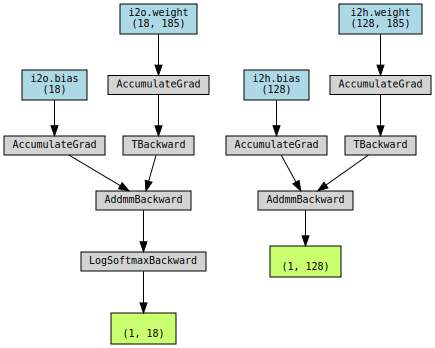

In [6]:
# I was curious to see how the RNN would be plotted and the result is quite interesting
from torchviz import make_dot

input_t = letter_to_tensor("A")
hidden_t = rnn.init_hidden()

make_dot(rnn(input_t, hidden_t), params=dict(list(rnn.named_parameters())))

### 4. Training

In [7]:
# Returns the category with the highest probability in the output
def category_from_output(output):
    category_index = torch.argmax(output).item()
    return all_categories[category_index]

# Selects a random training example
def random_training_example(category_names, all_categories):
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    name = random_choice(category_names[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    name_tensor = name_to_tensor(name)
    return category, name, category_tensor, name_tensor

# Executes the neural network's training
def train(name_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    # Iterate over the whole name
    for char in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[char], hidden)
    
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [8]:
# Training parameters
learning_rate = 0.005
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 250000

for iter in range(n_iters):
    category, name, category_tensor, name_tensor = random_training_example(category_names, all_categories)
    
    output, loss = train(name_tensor, category_tensor)
    current_loss += loss
    
    if (iter + 1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
    
    if (iter + 1) % print_steps == 0:
        guess = category_from_output(output)
        is_correct = "✓" if guess == category else f"✗ ({category})"
        print(f'Progress: {(iter/n_iters*100):.1f}% - Loss: {loss:.4f} - Name: {name} - Guess: {guess} {is_correct}')

Progress: 2.0% - Loss: 2.2258 - Name: Acerbi - Guess: Italian ✓
Progress: 4.0% - Loss: 2.2960 - Name: Salinas - Guess: Greek ✗ (Spanish)
Progress: 6.0% - Loss: 2.1375 - Name: Jituhin - Guess: Irish ✗ (Russian)
Progress: 8.0% - Loss: 2.3925 - Name: O'Donoghue - Guess: Russian ✗ (Irish)
Progress: 10.0% - Loss: 0.5797 - Name: Sinclair - Guess: Scottish ✓
Progress: 12.0% - Loss: 0.7813 - Name: Malouf - Guess: Arabic ✓
Progress: 14.0% - Loss: 2.3647 - Name: Simoes - Guess: Arabic ✗ (Portuguese)
Progress: 16.0% - Loss: 0.4922 - Name: Montanari - Guess: Italian ✓
Progress: 18.0% - Loss: 0.1160 - Name: Ryusaki - Guess: Japanese ✓
Progress: 20.0% - Loss: 1.4072 - Name: Faure - Guess: French ✓
Progress: 22.0% - Loss: 0.9300 - Name: Martinez - Guess: Spanish ✓
Progress: 24.0% - Loss: 1.7451 - Name: Jewers - Guess: Dutch ✗ (English)
Progress: 26.0% - Loss: 1.5610 - Name: Marek - Guess: Polish ✗ (Czech)
Progress: 28.0% - Loss: 0.6045 - Name: Hadad - Guess: Arabic ✓
Progress: 30.0% - Loss: 1.9153 - 

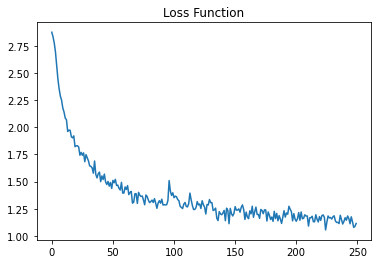

In [9]:
# Plot the loss function
plt.figure()
plt.plot(all_losses)
plt.title("Loss Function")
plt.show()

### 5. Evaluation

In [10]:
def predict(name):
    with torch.no_grad():
        name_tensor = name_to_tensor(name)
    
        hidden = rnn.init_hidden()

        for char in range(name_tensor.size()[0]):
            output, hidden = rnn(name_tensor[char], hidden)
        
        return category_from_output(output)

In [11]:
true = []
pred = []

for language in all_categories:
    names = category_names[language]
    true += [language for name in names]

    for name in names:
        guess = predict(name)
        pred.append(guess)

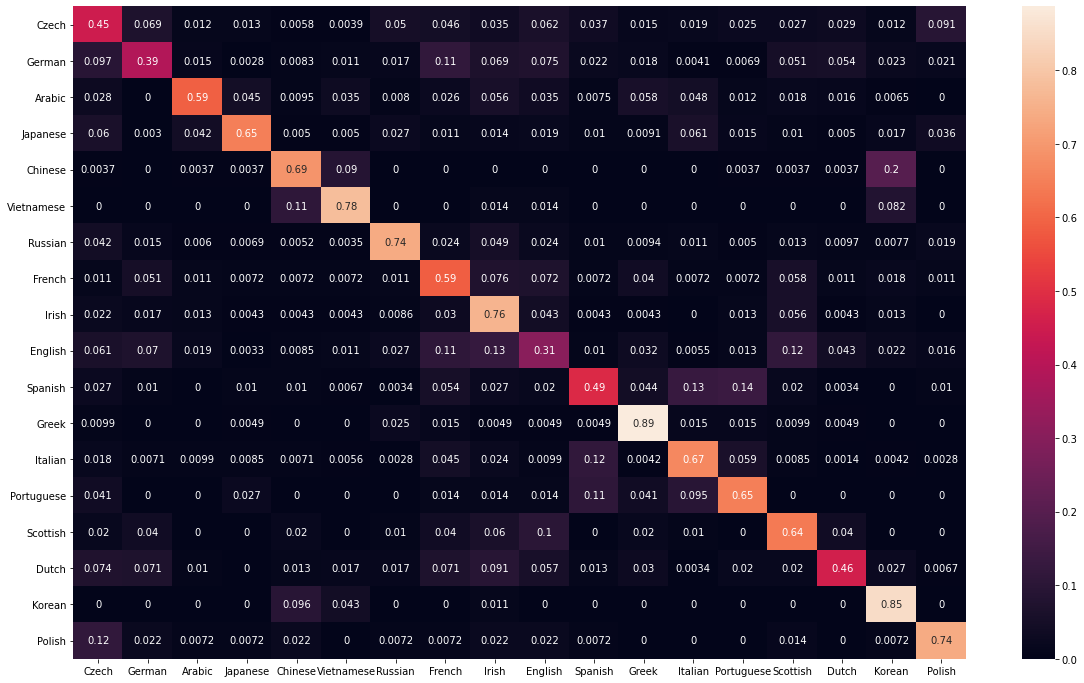

In [12]:
# Plot the confusion matrix
cm = confusion_matrix(true, pred, labels=all_categories)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Alternative
df_cm = pd.DataFrame(cm, columns=all_categories)
plt.figure(figsize = (20,12))
sn.heatmap(df_cm, annot=True, yticklabels=all_categories)
plt.show()

### 6. Testing

In [13]:
name = "Coelho"
guess = predict(name)

print("Your input:", name)
print("The model's guess:", guess)

Your input: Coelho
The model's guess: Portuguese
